In [151]:
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

# Libreria surprise para entrenamiento
from surprise import Dataset, Reader, SVD
from surprise.model_selection import train_test_split

In [152]:
# Cargar el conjunto de datos de scores
df = pd.read_csv("datasets/scores.csv")

# Cargar el conjunto de datos de movies para sacar luego el titulo de las peliculas
df_titles = pd.read_csv("datasets/movies_titles.csv")

In [153]:
# Del dataset de peliculas solo nos interesa quedarnos con el id y su titulo

df_titles = df_titles[['id','title']]

df_titles = df_titles.reset_index(drop=True)

df_titles

,id,title
0,as1,the grand seduction
1,as2,take care good night
2,as3,secrets of deception
3,as4,pink: staying true
4,as5,monster maker
...,...,...
22993,ns8803,zodiac
22994,ns8804,zombie dumb
22995,ns8805,zombieland
22996,ns8806,zoom


In [154]:
# Pasos previos a realización de la predicción

N_filas = 100000 # Limitamos el dataset a N_filas

reader = Reader(rating_scale=(1, 5))

data = Dataset.load_from_df(df[['userId', 'movieId', 'score']][:N_filas], reader)

# Separamos nuestros datos

trainset, testset = train_test_split(data, test_size=.25)


In [155]:
# Entrenamos el modelo SVD

model = SVD()

model.fit(trainset)

In [156]:
# Predecimos

predictions = model.test(testset)

In [157]:
predictions[1]

Prediction(uid=713, iid='hs1513', r_ui=4.5, est=3.684855765748993, details={'was_impossible': False})

In [158]:
# Hacemos una predicción con userId y movieId al azar

model.predict(9, 'ns5709')

Prediction(uid=9, iid='ns5709', r_ui=None, est=3.8650248144942636, details={'was_impossible': False})

### Predicción completa para un usuario aleatorio

In [159]:
# Tomaremos un usuario al azar para hacerle una recomendación

usuario = 44200
score = 4  # Tomamos películas a las que haya calificado con 4 o 5 estrellas
df_user = df[(df.userId == usuario) & (df.score >= score)]

df_user = df_user.reset_index(drop=True)

df_titles.rename(columns={'id': 'movieId'}, inplace=True)

df_user = pd.merge(df_user, df_titles[['movieId', 'title']], left_on='movieId', right_on='movieId', how='left')

df_user

,userId,score,timestamp,movieId,title
0,44200,5.0,2013-11-10,as6154,paranormal
1,44200,5.0,2013-11-04,ns1757,lego jurassic world: legend of isla nublar
2,44200,5.0,2013-11-04,ds360,planes
3,44200,4.0,2015-11-07,as149,water (short)
4,44200,4.0,2014-10-18,as9420,the sacrament
...,...,...,...,...,...
192,44200,4.5,2016-03-09,ns3960,mercy black
193,44200,4.0,2016-03-09,as9069,the joyriders
194,44200,4.0,2016-03-09,ns2761,kannum kannum kollaiyadithaal
195,44200,4.5,2016-03-09,hs697,vanguard


In [160]:
recomendaciones_usuario = df_titles.iloc[:23000].copy()
print(recomendaciones_usuario.shape)
recomendaciones_usuario.head()

(22998, 2)


,movieId,title
0,as1,the grand seduction
1,as2,take care good night
2,as3,secrets of deception
3,as4,pink: staying true
4,as5,monster maker


In [161]:
# Debemos extraer las películas que ya ha visto

usuario_vistas = df[df['userId'] == usuario]
print(usuario_vistas.shape)
usuario_vistas.head()

(337, 4)


,userId,score,timestamp,movieId
4254853,44200,3.5,2013-11-12,as4033
4254854,44200,5.0,2013-11-10,as6154
4254855,44200,5.0,2013-11-04,ns1757
4254856,44200,5.0,2013-11-04,ds360
4254857,44200,3.0,2013-11-23,hs2132


In [162]:
# Eliminamos las peliculas que el usuario ya vió

recomendaciones_usuario = recomendaciones_usuario[~recomendaciones_usuario['movieId'].isin(usuario_vistas['movieId'])]

recomendaciones_usuario.shape

(22663, 2)

In [163]:
# Recomendamos

recomendaciones_usuario['Estimate_Score'] = recomendaciones_usuario['movieId'].apply(lambda x: model.predict(usuario, x).est)

In [164]:
recomendaciones_usuario = recomendaciones_usuario.sort_values('Estimate_Score', ascending=False)
print(recomendaciones_usuario.head(10))

      movieId                                      title  Estimate_Score
11296   hs179                               the simpsons        4.073426
9895    ds228  fantastic four: rise of the silver surfer        4.055814
7288   as7289                          day of the reaper        3.993728
118     as119             where is chicky? - chapter two        3.993479
17725  ns3535                                    the spy        3.984310
19567  ns5377                              chasing coral        3.983034
546     as547                 the man in the high castle        3.977360
14549   ns359                                    the net        3.972543
8231   as8232                          the wheel of time        3.964648
2904   as2905                                   carriers        3.951285


### Predicción ingresando un id de usuario y uno de pelicula

In [165]:
def get_movie_recommendation(userId, movieId):
    # Obtenemos la predicción de la calificación que el usuario le daría a la película
    prediction = model.predict(str(userId), str(movieId))

    # Si la predicción es mayor o igual a 3.5, se recomienda la película
    if prediction.est >= 3.5:
        return "Recomendado", prediction.est
    else:
        return "No recomendado", prediction.est

In [166]:
# ID del usuario
user_id = 58

# ID de la película
movie_id = 'as12'

# Obtener la recomendación para el usuario y la película
recommendation = get_movie_recommendation(user_id, movie_id)

# Imprimir la recomendación
print("La película es:", recommendation)

La película es: ('No recomendado', 3.4409895570211986)


## Evaluación del modelo

In [167]:
# Evaluamos el accuracy del modelo

from surprise import accuracy

accuracy.rmse(predictions)

RMSE: 0.9572


0.9571505841060434

## Optimización de los hiperparametros

In [168]:
from surprise.model_selection import cross_validate
import numpy as np

rmse_test_means = []
factores = [1,2,4,8,16,32,64,128]

for factor in factores:
    print(factor)
    model = SVD(n_factors=factor)
    cv = cross_validate(model, data, measures=['RMSE'], cv = 3, verbose=True)
    rmse_test_means.append(np.mean(cv['test_rmse']))

1
Evaluating RMSE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.9511  0.9490  0.9469  0.9490  0.0017  
Fit time          0.49    0.51    0.50    0.50    0.01    
Test time         0.18    0.18    0.19    0.18    0.00    
2
Evaluating RMSE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.9526  0.9536  0.9436  0.9500  0.0045  
Fit time          0.55    0.52    0.57    0.55    0.02    
Test time         0.21    0.20    0.27    0.23    0.03    
4
Evaluating RMSE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.9569  0.9489  0.9448  0.9502  0.0050  
Fit time          0.56    0.52    0.54    0.54    0.01    
Test time         3.43    0.19    0.18    1.27    1.53    
8
Evaluating RMSE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.9488  0.9

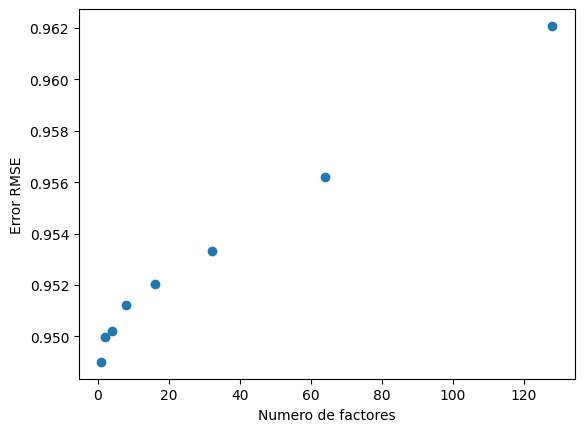

In [169]:
# Ploteamos desempeño según cantidad de factores de SVD

plt.scatter(factores, rmse_test_means)
plt.xlabel('Numero de factores')
plt.ylabel('Error RMSE')
plt.show()